#**Deteksi Kebocoran Pipa Minyak**

Fitur yang akan dimanfaatkan dalam penelitian ini adalah tekanan *inlet* dan *outlet, leak rate*, ID (*internal diameter*) pipa dan lokasi kebocoran. Dari fitur ini, dilakukan dua studi kasus:

##**Studi Kasus**




Pada studi kasus pertama, data *input* terdiri dari 3 variabel yaitu *pressure inlet* dan *pressure outlet*, dan *leak rate*, sedangkan ID pipanya tetap. Output yang ingin dihasilkan adalah lokasi kebocoran pipa minyak (*leak location*). Untuk selanjutnya data tekanan inlet dan tekanan outlet dapat digabungkan menjadi satu fitur, yakni selisihnya atau *delta pressure*.

### **LIBRARY** ###

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras_tuner.tuners import RandomSearch

Data kemudian diambil dan dibagi atas data training dan data testing dengan ratio 80:20.

###**PREPARING DATA**

In [ ]:
def preparingData():
    df_raw = pd.read_excel("Data_Kebocoran_Pipa_Minyak.xlsx")
    df = df_raw[["delta pressure","Leak rate (STB/d)","leak_location"]]
    return df

In [ ]:
df = preparingData()

In [ ]:
df

,delta pressure,Leak rate (STB/d),leak_location
0,186.5110,280,200
1,186.5202,280,400
2,186.5295,280,600
3,186.5388,280,800
4,186.5473,280,1000
...,...,...,...
1990,189.9998,1400,79000
1991,190.0337,1400,79200
1992,190.0667,1400,79400
1993,190.0995,1400,79600


###**PREPROCESSING DATA**

In [ ]:
def preprocessingData(df):
  X = df.iloc[:,:2]       # x disini sebagai input yaitu leak rate ,
  # mengambil iloc[baris,kolom] = [:,:2] yaitu data pada semua baris di kolom 0,1
  y = df["leak_location"] # y disini sebagai input yaitu leak_location

  # 'test_size=0.2' menentukan proporsi data yang akan digunakan sebagai data uji (20% dari total data),
  # 'random_state=50' digunakan untuk mengatur pembagian data secara acak dengan seed 50 agar dapat direproduksi.
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train,y_test = preprocessingData(df)

In [ ]:
print(f'Jumlah x_train : {len(X_train)}')
print(f'Jumlah y_train : {len(y_train)}')
print()
print(f'Jumlah x_test : {len(X_test)}')
print(f'Jumlah y_test : {len(y_test)}')

Jumlah x_train : 1596
Jumlah y_train : 1596

Jumlah x_test : 399
Jumlah y_test : 399


In [ ]:
print("X_train\n", X_train)
print("X_test\n", X_test)
print("y_train\n", y_train)
print("y_test\n", y_test)

X_train
       delta pressure  Leak rate (STB/d)
233         188.6433                280
245         188.7532                280
1410        183.4457               1120
1840        183.4835               1400
561         185.8431                560
...              ...                ...
1313        179.9461               1120
109         187.5086                280
1931        187.7859               1400
1504        186.8399               1120
1712        177.4540               1400

[1596 rows x 2 columns]
X_test
       delta pressure  Leak rate (STB/d)
1738        178.6203               1400
1015        185.2102                840
589         186.3532                560
957         183.6321                840
828         180.1247                840
...              ...                ...
158         187.9568                280
1610        172.8763               1400
770         189.6532                560
1869        184.9581               1400
496         184.6594                56

#**BASELINE ANALYSIS MODEL**
Pertama, dibangun sebuah model baseline ANN digunakan sebagai acuan model lainnya dengan arsitektur yang berbeda. Arsitektur dari model baseline yang dibuat terdiri dari 1 input layer, 2 hidden layer dengan masing-masing layer memiliki 64 neuron dan menggunakan ReLU (rectified linear units) sebagai fungsi aktivasi, dan 1 output layer dengan 1 neuron. Loss function yang digunakan adalah MAE (Mean Absolute Error)

In [ ]:
def createFeaturesScallingLayer(X_train):
    normalize = layers.Normalization()
    normalize.adapt(X_train)
    return normalize

In [ ]:
normalize = createFeaturesScallingLayer(X_train)

In [ ]:
# membuat deep learning nya
def baselineANN():
    model = keras.Sequential() # layer ditambahkan manual satu per satu
    model.add(layers.InputLayer(input_shape = (2,)))
    # 2 karena kita diatas hanya pakai 2 input yaitu delta pressure dan Leak rate (STB/d)
    model.add(normalize) # menormalisasikan agar performa lebih baik dan komputasi lebih cepat
    model.add(layers.Dense(64,activation="relu"))   #layer tersembunyi pertama dengan 64 neuron
    model.add(layers.Dense(64,activation="relu"))   #layer tersembunyi kedua debagb 64 neuron
    model.add(layers.Dense(1,name="output_layer"))  # 1 output layer dengan 1 neuron

    model.compile(loss="mean_absolute_error",
                  optimizer=keras.optimizers.Adam(),
                  metrics = ["mean_absolute_error"]) # untuk nampilin hasil mean absolute error
    return model

In [ ]:
baselineModel = baselineANN()

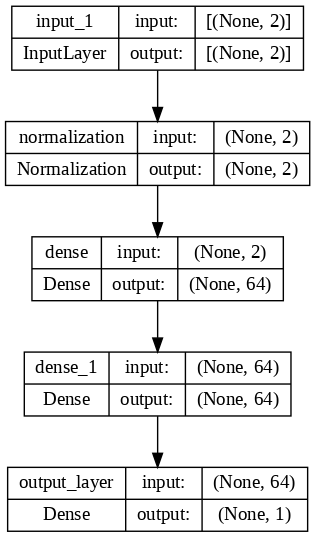

In [ ]:
plot_model(baselineModel,show_shapes=True,dpi=100, show_layer_names=True)

Model baseline di-training dengan data training sebanyak 200 epochs. Kemudian, dilakukan evaluasi model menggunakan data testing dan dihasilkan error yang semakin lama semakin mengecil seperti pada plot.

In [ ]:
def trainModel(model,X_train,y_train):
    history = model.fit(X_train,y_train, epochs=200,steps_per_epoch=25, validation_split = 0.2, verbose = 0)
    return history

In [ ]:
history = trainModel(baselineModel, X_train, y_train)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error[Leak location]')
    plt.legend()
    plt.grid(True)

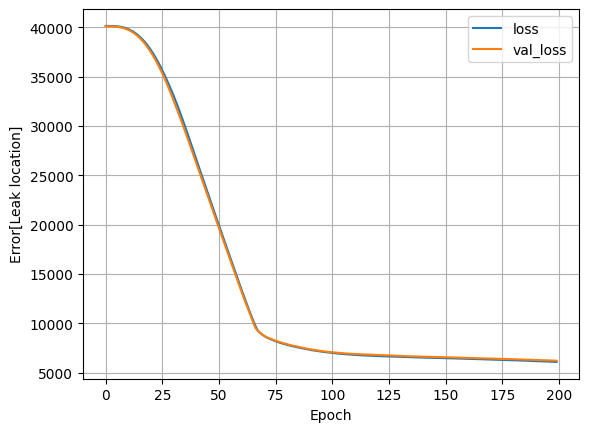

In [ ]:
plot_loss(history)

Berikut adalah perbandingan hasil prediksi dengan data sebenarnya untuk semua leak rate

In [ ]:
def plot_predVStrue(model,X,y):
    predictions = model.predict(X).flatten()
    a = plt.axes(aspect='equal')
    plt.scatter(predictions,y)
    plt.xlabel('True Values [Leak location]')
    plt.ylabel('Predictions [Leak location]')
    lims = [0,80000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims,lims,color='red')


13/13 [==============================] - 0s 2ms/step


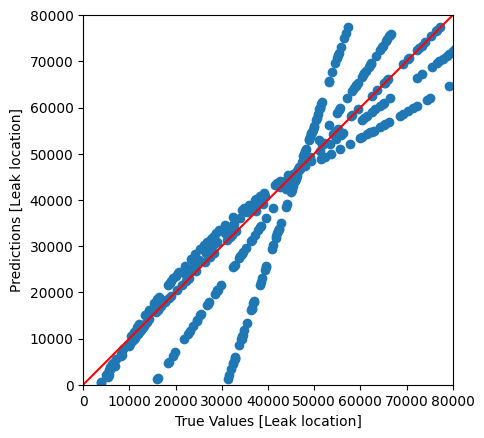

In [ ]:
plot_predVStrue(baselineModel,X_test, y_test)

In [ ]:
def plot_perLeakRate(model,X,y):
    idx = X.index[X['Leak rate (STB/d)'] == 280].tolist()
    d_280 = X.loc[idx]
    pred_280 = model.predict(d_280)
    sim_280 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 560].tolist()
    d_560 = X.loc[idx]
    pred_560 = model.predict(d_560)
    sim_560 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 840].tolist()
    d_840 = X.loc[idx]
    pred_840 = model.predict(d_840)
    sim_840 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 1120].tolist()
    d_1120 = X.loc[idx]
    pred_1120 = model.predict(d_1120)
    sim_1120 = y.loc[idx]

    idx = X.index[X['Leak rate (STB/d)'] == 1400].tolist()
    d_1400 = X.loc[idx]
    pred_1400 = model.predict(d_1400)
    sim_1400 = y.loc[idx]

    fig,axs = plt.subplots(2, 3, figsize = (15,10))
    axs[0,0].plot( sim_280, sim_280, color='red')
    axs[0,0].scatter(pred_280, sim_280, color='blue')
    axs[0,0].set_title('Rate 280 STB/D')

    axs[0,1].plot( sim_560, sim_560, color='red')
    axs[0,1].scatter(pred_560, sim_560, color='orange')
    axs[0,1].set_title('Rate 560 STB/D')

    axs[0,2].plot( sim_840, sim_840, color='red')
    axs[0,2].scatter(pred_840, sim_840, color='green')
    axs[0,2].set_title('Rate 840 STB/D')

    axs[1,0].plot( sim_1120, sim_1120, color='red')
    axs[1,0].scatter(pred_1120, sim_1120, color='purple')
    axs[1,0].set_title('Rate 1120 STB/D')

    axs[1,1].plot( sim_1400, sim_1400, color='red')
    axs[1,1].scatter(pred_1400, sim_1400, color='brown')
    axs[1,1].set_title('Rate 1400 STB/D')

    for ax in axs.flat:
        ax.set(xlabel='prediction', ylabel='simulation')

In [ ]:
print(X_test, y_test)

      delta pressure  Leak rate (STB/d)
1738        178.6203               1400
1015        185.2102                840
589         186.3532                560
957         183.6321                840
828         180.1247                840
...              ...                ...
158         187.9568                280
1610        172.8763               1400
770         189.6532                560
1869        184.9581               1400
496         184.6594                560

[399 rows x 2 columns] 1738    28600
1015    43600
589     38200
957     32000
828      6200
        ...  
158     31800
1610     3000
770     74400
1869    54800
496     19600
Name: leak_location, Length: 399, dtype: int64


In [ ]:
print(baselineModel)

Sedangkan perbandingan antara data asli kebocoran dan data prediksi kebocorannya untuk setiap leak rate dapat dilihat:

3/3 [==============================] - 0s 3ms/step


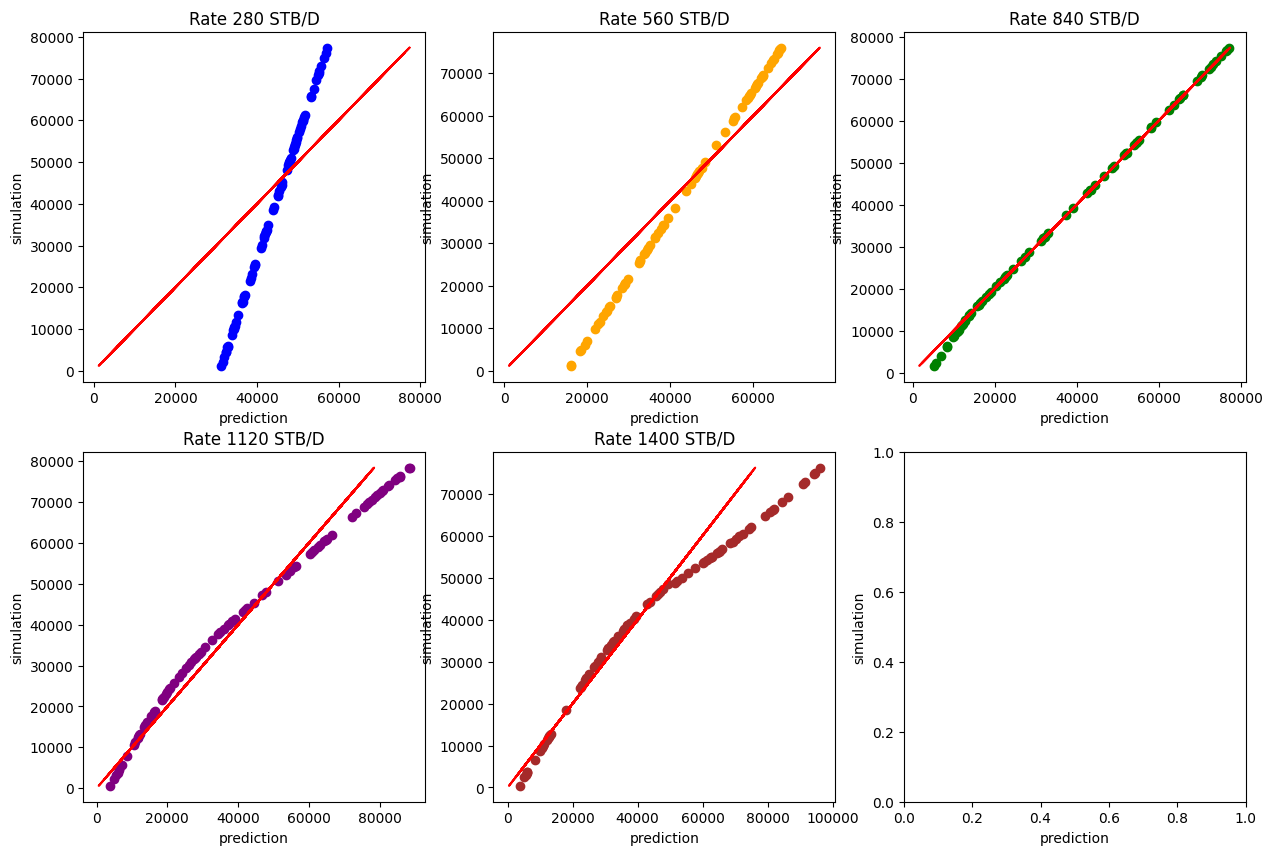

In [ ]:
plot_perLeakRate(baselineModel,X_test,y_test)

Hasil perdiksi untuk setiap kasus leak rate. Garis merah menunjukkan hasil yang seharusnya.

In [ ]:
def evaluate(model,X_train,X_test, y_train, y_test):
    print(f'Mean absolute error for train data {mean_absolute_error(y_train,model.predict(X_train)) :.5f}')
    print(f'Mean absolute error for test data {mean_absolute_error(y_test,model.predict(X_test)) :.5f}')

In [ ]:
evaluate(baselineModel, X_train, X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 6113.40925
13/13 [==============================] - 0s 2ms/step
Mean absolute error for test data 5861.12794


Dapat Dilihat bahwa MAE model Baseline sebagai berikut:


1.   MAE untuk data training :5872.68048
2.   MAE untuk data test: 5551.92709



Dari hasil di atas, dapat disimpulkan model baseline masih belum akurat memprediksi lokasi kebocoran pipa.

In [ ]:
X_test.head()

,delta pressure,Leak rate (STB/d)
1738,178.6203,1400
1015,185.2102,840
589,186.3532,560
957,183.6321,840
828,180.1247,840


In [ ]:
baselineModel.predict(X_test)

13/13 [==============================] - 0s 2ms/step


array([[26622.506 ],
       [43410.28  ],
       [41062.77  ],
       [31801.469 ],
       [ 8267.585 ],
       [38741.066 ],
       [45228.188 ],
       [61461.914 ],
       [35237.49  ],
       [33002.055 ],
       [74377.83  ],
       [51092.586 ],
       [16848.717 ],
       [55308.605 ],
       [21832.098 ],
       [28214.137 ],
       [20708.94  ],
       [25486.412 ],
       [12233.954 ],
       [62908.086 ],
       [65027.727 ],
       [80511.88  ],
       [12764.61  ],
       [12060.72  ],
       [50335.336 ],
       [44207.367 ],
       [24404.123 ],
       [29145.264 ],
       [ 5301.8647],
       [62186.457 ],
       [11965.999 ],
       [43935.32  ],
       [34889.477 ],
       [38219.973 ],
       [47565.45  ],
       [31818.543 ],
       [36518.125 ],
       [42302.56  ],
       [49859.523 ],
       [48226.086 ],
       [49278.266 ],
       [ 6794.0522],
       [19526.027 ],
       [69276.36  ],
       [85854.68  ],
       [16090.371 ],
       [35431.164 ],
       [62207

#**HYPERPARAMETER TUNING**

Selanjutnya, model akan dilatih dengan memanfaatkan *Hyperparameter tuning* yaitu metode pencarian parameter terbaik untuk performa suatu model. Ada beberapa metode standar yang biasa digunakan dalam *Hyperparameter tuning* antara lain *grid search* dan *random search*.

Oleh karena itu maka dibangun beberapa model dengan banyaknya *hidden layer* adalah 2 sampai 7. Setiap model itu akan dilakukan pencarian jumlah *neuron* setiap *layer* dan *learning rate* yang terbaik menggunakan teknik *Hyperparameter Tuning*. Perbandingan MAE di antara model-model tersebut akan dilihat.

##**2 Layers**

In [ ]:
def build_model_2(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range (0,2):
        optimized_model.add(layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=512,step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer2(X_train, y_train):
    tuner2 = RandomSearch(build_model_2,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 2 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner2.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner2

In [ ]:
print(layer2)

<function layer2 at 0x7a544c4aae60>


In [ ]:
%%time
tuner2 = layer2(X_train, y_train)

Trial 10 Complete [00h 00m 42s]
val_mean_absolute_error: 3138.16552734375

Best val_mean_absolute_error So Far: 108.49555969238281
Total elapsed time: 00h 07m 35s
CPU times: user 6min 17s, sys: 20.5 s, total: 6min 38s
Wall time: 7min 35s


In [ ]:
print(tuner2)

###**Best Model**

In [ ]:
def bestModel(tuner):
    model = tuner.get_best_models()[0]
    return model

In [ ]:
best_2layers = bestModel(tuner2)

In [ ]:
print(best_2layers)

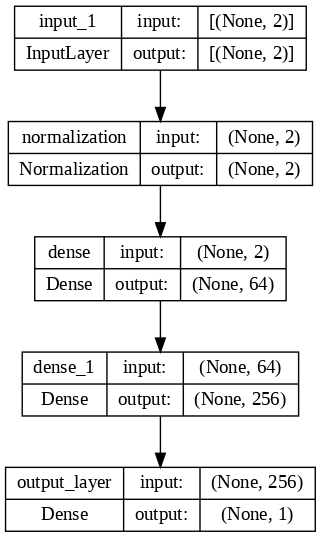

In [ ]:
plot_model(best_2layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_2layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 102.52012
13/13 [==============================] - 0s 2ms/step
Mean absolute error for test data 94.27248


In [ ]:
def saveModel(model,layer):
    model.save('model_' + str(layer) + 'layers.h5')

In [ ]:
from keras.models import load_model

loaded_model_2 = load_model('model_2layers.h5')


In [ ]:
loaded_model_2

In [ ]:
def printBestHps(layers,tuner):
    best_hps = tuner.get_best_hyperparameters(1)[0]
    for i in range(layers):
        print(f'units_{i}:', best_hps.get(f"units_{i}"))
    print('learning_rate:', best_hps.get('learning_rate'))

In [ ]:
printBestHps(2,tuner2)

units_0: 64
units_1: 256
learning_rate: 0.01


##**3 Layers**

In [ ]:
def build_model_3(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range(0, 3):
        optimized_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer3(X_train, y_train):
    tuner3 = RandomSearch(build_model_3,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 3 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner3.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner3

In [ ]:
%%time
tuner3 = layer3(X_train, y_train)

Trial 10 Complete [00h 00m 42s]
val_mean_absolute_error: 1813.8443603515625

Best val_mean_absolute_error So Far: 110.09095764160156
Total elapsed time: 00h 08m 21s
CPU times: user 7min 38s, sys: 23.8 s, total: 8min 2s
Wall time: 8min 21s


In [ ]:
printBestHps(3,tuner3) # fungsi printBestHPs sudah didefinisikan pada model dengan 2 hidden layer

units_0: 160
units_1: 288
units_2: 320
learning_rate: 0.001


###**Best Model**

In [ ]:
best_3layers = bestModel(tuner3)

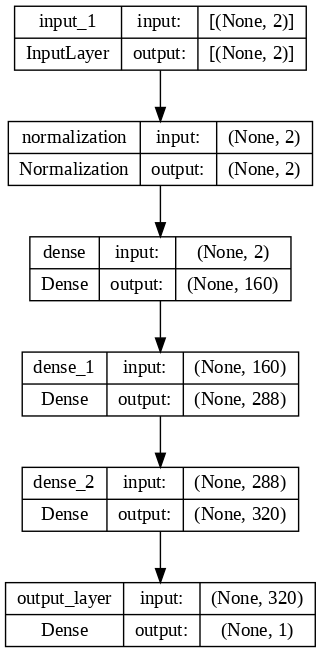

In [ ]:
plot_model(best_3layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_3layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 109.70441
13/13 [==============================] - 0s 3ms/step
Mean absolute error for test data 102.42638


In [ ]:
saveModel(best_3layers,3)

In [ ]:
from keras.models import load_model

loaded_model_3 = load_model('model_3layers.h5')


In [ ]:
loaded_model_3

##**4 Layers**

In [ ]:
def build_model_4(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range(0, 4):
        optimized_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer4(X_train, y_train):
    tuner4 = RandomSearch(build_model_4,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 4 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner4.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner4

In [ ]:
%%time
tuner4 = layer4(X_train, y_train)

Trial 10 Complete [00h 00m 50s]
val_mean_absolute_error: 256.0599670410156

Best val_mean_absolute_error So Far: 57.15315628051758
Total elapsed time: 00h 10m 31s
CPU times: user 9min 2s, sys: 28.5 s, total: 9min 31s
Wall time: 10min 30s


In [ ]:
printBestHps(4,tuner4) # fungsi printBestHPs sudah didefinisikan pada model dengan 2 hidden layer

units_0: 480
units_1: 192
units_2: 224
units_3: 416
learning_rate: 0.001


###**Best Model**

In [ ]:
best_4layers = bestModel(tuner4)

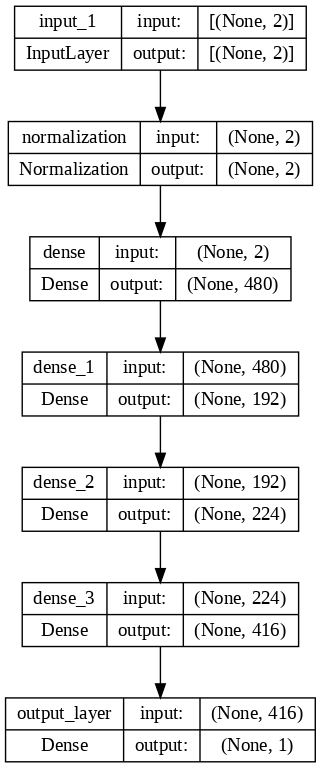

In [ ]:
plot_model(best_4layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_4layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 56.30158
13/13 [==============================] - 0s 5ms/step
Mean absolute error for test data 56.07985


In [ ]:
saveModel(best_4layers,4)

In [ ]:
from keras.models import load_model

loaded_model_4 = load_model('model_4layers.h5')


In [ ]:
loaded_model_4

##**5 Layers**

In [ ]:
def build_model_5(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range(0, 5):
        optimized_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer5(X_train, y_train):
    tuner5 = RandomSearch(build_model_5,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 5 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner5.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner5

In [ ]:
%%time
tuner5 = layer5(X_train, y_train)

Trial 10 Complete [00h 01m 25s]
val_mean_absolute_error: 302.24554443359375

Best val_mean_absolute_error So Far: 72.62955474853516
Total elapsed time: 00h 11m 41s
CPU times: user 10min 17s, sys: 30.8 s, total: 10min 48s
Wall time: 11min 41s


In [ ]:
printBestHps(5,tuner5) # fungsi printBestHPs sudah didefinisikan pada model dengan 2 hidden layer

units_0: 416
units_1: 320
units_2: 288
units_3: 96
units_4: 384
learning_rate: 0.001


###**Best Model**

In [ ]:
best_5layers = bestModel(tuner5)

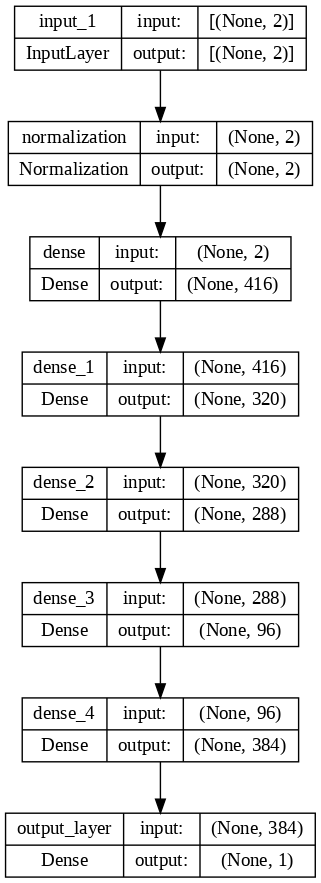

In [ ]:
plot_model(best_5layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_5layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 5ms/step
Mean absolute error for train data 74.29011
13/13 [==============================] - 0s 4ms/step
Mean absolute error for test data 69.27533


In [ ]:
saveModel(best_5layers,5)

In [ ]:
from keras.models import load_model

loaded_model_5 = load_model('model_5layers.h5')


In [ ]:
loaded_model_5

##**6 Layers**

In [ ]:
def build_model_6(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range(0, 6):
        optimized_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer6(X_train, y_train):
    tuner6 = RandomSearch(build_model_6,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 6 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner6.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner6

In [ ]:
%%time
tuner6 = layer6(X_train, y_train)

Trial 10 Complete [00h 01m 15s]
val_mean_absolute_error: 344.9415283203125

Best val_mean_absolute_error So Far: 69.33135986328125
Total elapsed time: 00h 15m 04s
CPU times: user 14min 14s, sys: 41.7 s, total: 14min 56s
Wall time: 15min 3s


In [ ]:
printBestHps(6,tuner6) # fungsi printBestHPs sudah didefinisikan pada model dengan 2 hidden layer

units_0: 224
units_1: 288
units_2: 416
units_3: 384
units_4: 192
units_5: 64
learning_rate: 0.001


###**Best Model**

In [ ]:
best_6layers = bestModel(tuner6)

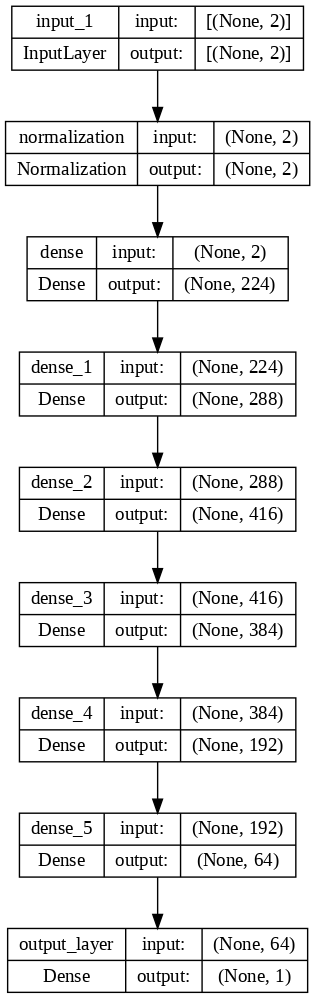

In [ ]:
plot_model(best_6layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_6layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 4ms/step
Mean absolute error for train data 74.57344
13/13 [==============================] - 0s 4ms/step
Mean absolute error for test data 78.20523


In [ ]:
saveModel(best_6layers,6)

In [ ]:
from keras.models import load_model

loaded_model_6 = load_model('model_6layers.h5')


In [ ]:
loaded_model_6

##**7 Layers**

In [ ]:
def build_model_7(hp):
    optimized_model = keras.Sequential()
    optimized_model.add(layers.InputLayer(input_shape=(2,)))
    optimized_model.add(normalize)
    for i in range(0, 7):
        optimized_model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                         activation='relu'))
    optimized_model.add(layers.Dense(1, name='output_layer'))
    optimized_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                            loss='mean_absolute_error',
                            metrics=['mean_absolute_error'])
    return optimized_model

In [ ]:
def layer7(X_train, y_train):
    tuner7 = RandomSearch(build_model_7,
                          objective='val_mean_absolute_error',
                          max_trials=10,
                          executions_per_trial=1,
                          directory="TUning Project 7 Layers",
                          project_name='OPPINET Leak Detector',
                          overwrite=True)
    tuner7.search(X_train,
                  y_train,
                  epochs=200,
                  steps_per_epoch=25,
                  #validation_data = (X_test_scaled, y_test),
                  validation_split=0.2,
                  verbose=1)
    return tuner7

In [ ]:
%%time
tuner7 = layer7(X_train, y_train)

Trial 10 Complete [00h 01m 24s]
val_mean_absolute_error: 305.5434875488281

Best val_mean_absolute_error So Far: 76.89607238769531
Total elapsed time: 00h 16m 13s
CPU times: user 15min 42s, sys: 47.5 s, total: 16min 30s
Wall time: 16min 12s


In [ ]:
printBestHps(7,tuner7) # fungsi printBestHPs sudah didefinisikan pada model dengan 2 hidden layer

units_0: 512
units_1: 64
units_2: 64
units_3: 64
units_4: 128
units_5: 160
units_6: 192
learning_rate: 0.001


###**Best Model**

In [ ]:
best_7layers = bestModel(tuner7)

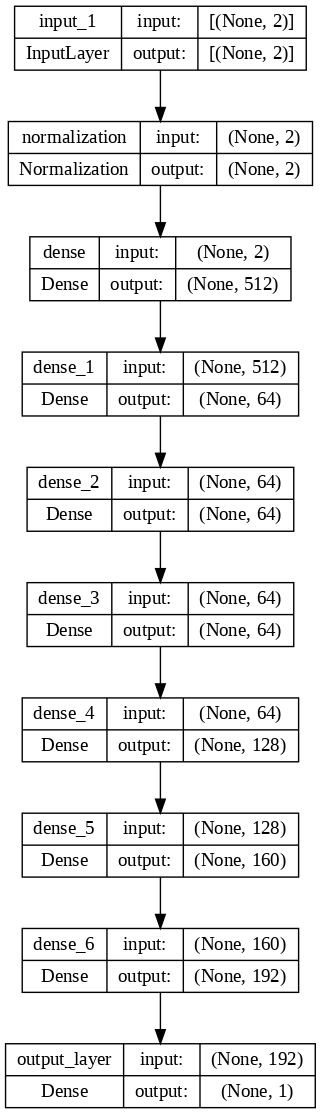

In [ ]:
plot_model(best_7layers, show_shapes=True, dpi=100, show_layer_names=True)

In [ ]:
evaluate(best_7layers,X_train,X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 78.38911
13/13 [==============================] - 0s 2ms/step
Mean absolute error for test data 76.69860


In [ ]:
saveModel(best_7layers,7)

In [ ]:
from keras.models import load_model

loaded_model_7 = load_model('model_7layers.h5')


In [ ]:
loaded_model_7

##**Perbandingan tuning model untuk 2-7 hidden layer**

Setelah melakukan tuning model untuk 3-7 hidden layer dengan kode yang sama seperti sebelumnya maka kemudian setiap model tersebut dievaluasi untuk membandingkan MAEnya dengan kode berikut.

In [ ]:
def maeEachModels(X_train, X_test, y_train, y_test):
  models = []
  for i in range(2,8):
    models.append(keras.models.load_model('model_'+str(i) + 'layers.h5'))

  train_mae = []
  test_mae = []
  for model in models:
    train_mae.append(mean_absolute_error(y_train, model.predict(X_train)))
    test_mae.append(mean_absolute_error(y_test, model.predict(X_test)))

  return models, train_mae, test_mae

In [ ]:
models, train_mae, test_mae = maeEachModels(X_train, X_test, y_train, y_test)

13/13 [==============================] - 0s 2ms/step


**Hasil evaluasi kemudian diplot seperti berikut:**

In [ ]:
def plotMaeEachModels(train_mae, test_mae):
  labels = ["2 layers", "3 layers", "4 layers", "5 layers", "6 layers", "7 layers", ]
  x = np.arange(len(labels))
  width = 0.35

  fig,ax = plt.subplots(figsize=(9,5))
  rects1 = ax.bar(x - width/2, train_mae, width, label = 'Train')
  rects2 = ax.bar(x + width/2, test_mae, width, label = 'Test')

  ax.set_ylabel('MAE')
  ax.set_title('MAE vs Layers')
  ax.set_xticklabels(["0"] + labels)
  ax.legend()

  plt.show()

In [ ]:
print(train_mae, test_mae)

[102.520123274404, 109.70440679564511, 56.30158274753351, 74.29011093942742, 74.57344479668409, 78.38910755358245] [94.27247791720512, 102.42637706938244, 56.07985394700129, 69.27533173142818, 78.2052309423461, 76.69860403878349]


<ipython-input-123-7e1ce1bc15cb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0"] + labels)


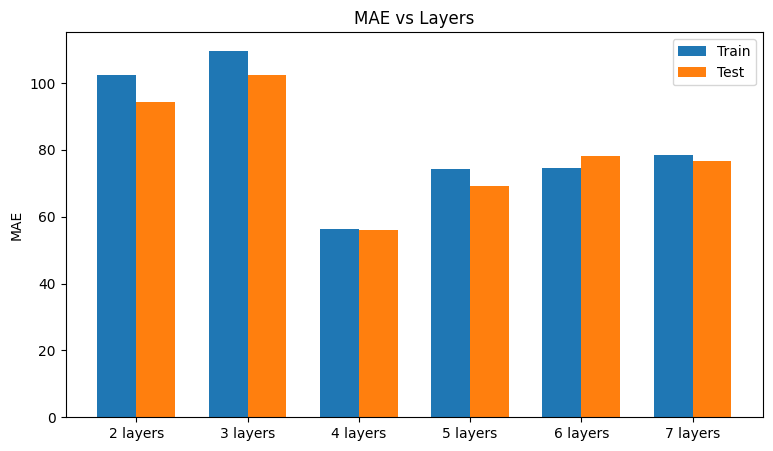

In [ ]:
plotMaeEachModels(train_mae, test_mae)

**Didapatkan model terbaik adalah model dengan 4 hidden layer**. Dengan hidden layer 1 banyaknya neuron sebanyak 480, hidden layer 2 banyaknya neuron 192, hidden layer 3 banyaknya neuron 224, hidden layer 4 banyaknya neuron 352, dan learning rate yang digunakan adalah 0.001. Kemudian, evaluasi model dilakukan menggunakan data testing dan dihasilkan perbandingan antara data asli kebocoran dan data prediksi kebocorannya untuk setiap *leak rate* yaitu :


3/3 [==============================] - 0s 8ms/step


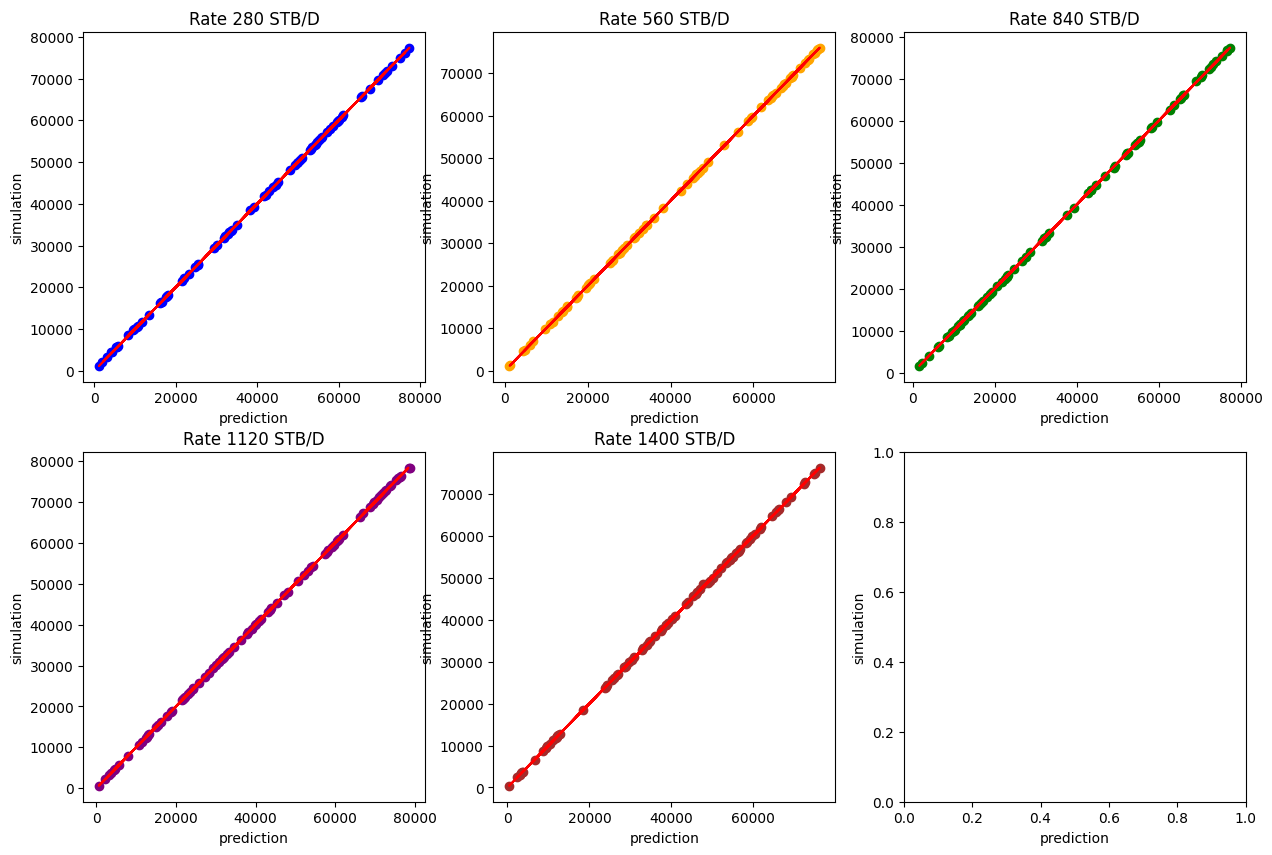

In [ ]:
plot_perLeakRate(best_4layers,X_test,y_test)

**Hasil prediksi untuk setiap kasus *leak rate* setelah *hyperparameter tuning***

In [ ]:
def finalANN(test_mae, models):
  idx = test_mae.index(min(test_mae))
  return models[idx]

In [ ]:
finalModel = finalANN(test_mae, models)

In [ ]:
evaluate(finalModel, X_train, X_test, y_train, y_test)

50/50 [==============================] - 0s 2ms/step
Mean absolute error for train data 56.30158
13/13 [==============================] - 0s 2ms/step
Mean absolute error for test data 56.07985


Dapat dilihat MAE model tersebut adalah:
*   MAE untuk data *training*: 56.30158
*   MAE untuk data *test*: 56.07985



#**Studi Kasus**

Data yang tersedia dibagi menjadi data pelatihan (porsi 80%) dan data *testing* (porsi 20%). Untuk mempermudah pelatihan model, *scaling* dilakukan pada data *input*

In [ ]:
import tensorflow as tf

In [ ]:
def build_and_complie_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss = 'mean_squared_error',
                optimizer = tf.keras.optimizers.Adam(0.001))
  return model


In [ ]:
def buildANN(number_of_hlayers = 3, first_u = 32, units = 64, last_u = 32, learning_rate = 0.001):
  # initializing the ANN
  ann = tf.keras.Sequential()

  # adding the first hidden layer
  ann.add(tf.keras.layers.Dense(units = first_u, input_dim = 2, activation = 'relu')) # Dense --> layer fully connected

  # adding subsequent hidden layers
  for i in range(number_of_hlayers = 2):
    ann.add(tf.keras.layers.Dense(units = last_u, activation = 'relu'))

  # adding the output layer
  ann.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))

  # compile ann
  ann.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      loss = 'mean_squared_error'
  )
  return ann

In [ ]:
normalizer = tf.keras.layers.Normalization(axis = 1)
normalizer.adapt(np.array(X_train))

In [ ]:
model = build_and_complie_model(normalizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 128)               384       
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                      

Epoch 1/800
13/13 [==============================] - 3s 42ms/step - loss: 2144943488.0000 - val_loss: 2056966144.0000
Epoch 2/800
13/13 [==============================] - 0s 25ms/step - loss: 1796979200.0000 - val_loss: 838483264.0000
Epoch 3/800
13/13 [==============================] - 0s 27ms/step - loss: 581513216.0000 - val_loss: 229298112.0000
Epoch 4/800
13/13 [==============================] - 0s 23ms/step - loss: 218817760.0000 - val_loss: 146196560.0000
Epoch 5/800
13/13 [==============================] - 0s 25ms/step - loss: 165156656.0000 - val_loss: 138514256.0000
Epoch 6/800
13/13 [==============================] - 0s 25ms/step - loss: 140518768.0000 - val_loss: 114972000.0000
Epoch 7/800
13/13 [==============================] - 0s 23ms/step - loss: 117582200.0000 - val_loss: 101264064.0000
Epoch 8/800
13/13 [==============================] - 0s 24ms/step - loss: 99189464.0000 - val_loss: 73154488.0000
Epoch 9/800
13/13 [==============================] - 0s 25ms/step - los

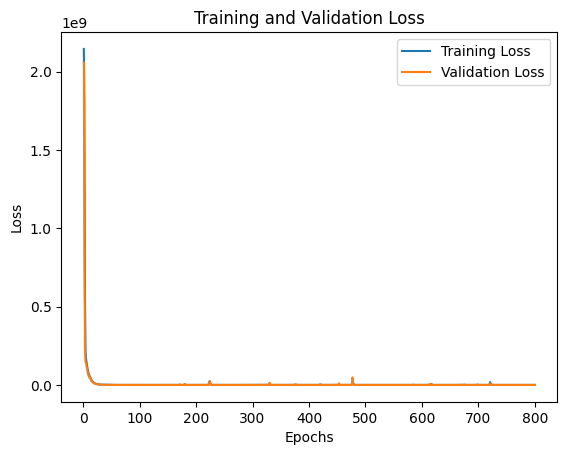

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_test, y_test),
                    batch_size=128, epochs=800)

# Get the loss and val_loss from the history object
loss_data = history.history['loss']
val_loss_data = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(loss_data) + 1)

# Plot the curves for loss and val_loss
plt.plot(epochs, loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import seaborn as sns

13/13 [==============================] - 0s 5ms/step


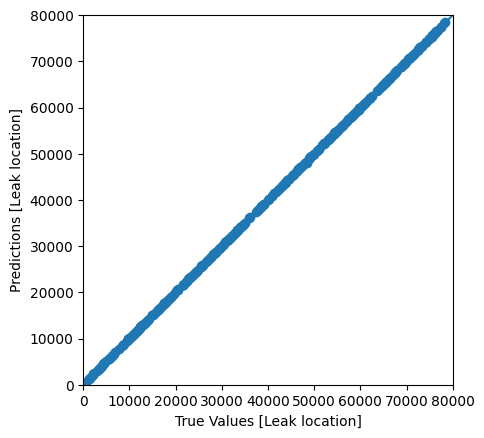

In [ ]:

test_predictions = model.predict(X_test)

a = plt.axes(aspect = 'equal')
plt.scatter(y_test, test_prediction)
plt.xlabel('True Values [Leak location]')
plt.ylabel('Predictions [Leak location]')
lims = [0, 80000]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)


[Text(0.5, 0, 'Test True Y'),
 Text(0, 0.5, 'Model Predictions'),
 Text(0.5, 1.0, 'Model Predictions vc Perfect Fit')]

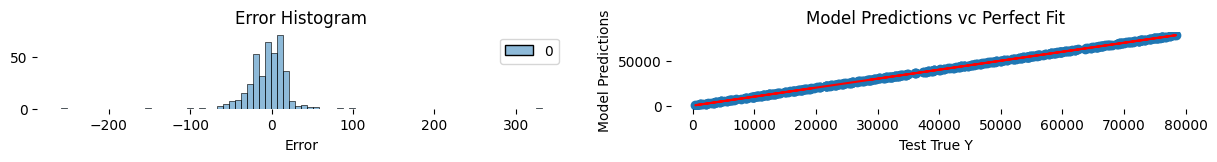

<Figure size 2000x2000 with 0 Axes>

In [ ]:
f, axes = plt.subplots(1, 2, figsize = (15,1))

#  model predictions
plt.scatter(y_test, test_predictions)

# perfect predictions
plt.plot(y_test, y_test, 'r')


# Assuming you have calculated the errors previously
errors = y_test.values.reshape(y_test.shape[0], 1) - test_predictions
sns.histplot(errors, ax=axes[0])

sns.despine(left = True, bottom = True)
plt.figure(figsize = (20,20)) # adjust the width and height as desired
axes[0].set(xlabel = 'Error', ylabel = '', title = 'Error Histogram')
axes[1].set(xlabel = 'Test True Y', ylabel = 'Model Predictions', title = 'Model Predictions vc Perfect Fit')

Dari hasil grafik di atas terlihat bahwa model sudah dapat memprediksi dengan cukup baik data test. Dengan titik-titik biru yang merupakan nilai prediksi sudah berada di sekitar garis merah yang merupakan nilai sebenarnya.

In [ ]:
pip install scikeras


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

param_grid = {
    'model_number_of_hlayers': [4, 5, 6, 7, 8, 9, 10],
    'model_units': [128, 192],
    'model_learning_rate': [0.00001, 0.0001, 0.001],
}
print("Start executing GridSearchCV Function")
grid_search = HalvingGridSearchCV(
    estimator=KerasRegressor(model=buildANN, epochs=1000, batch_size=128, verbose=0),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)

print("Done executing GridSearchCV function")
print("Start executing fit function")
grid_search.fit(X_train, y_train, verbose=0)
print("Done executing fit function")

best_parameters = grid_search.best_params_
print(f'best parameters: (best_parameters)')
